<a href="https://colab.research.google.com/github/pena-rodrigo/golombCA1/blob/main/clustering_SS_CS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-learn-extra

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.1 MB/s eta 0:00:00


In [ ]:
import random 
import time
import warnings
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from scipy.signal import savgol_filter
from sklearn.cluster import KMeans 
from sklearn_extra.cluster import KMedoids
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import seaborn as sns
%matplotlib inline

# mount drive
from google.colab import drive
drive.mount('/content/gdrive')
images_dir = '/content/gdrive/MyDrive/data_eric'

sns.set(font_scale=1.4)
sns.set_theme(style='white')

Mounted at /content/gdrive


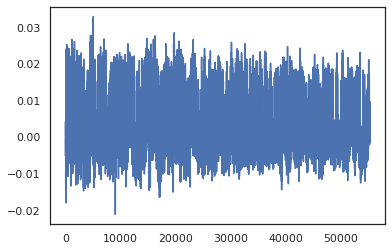

In [ ]:
dataload = np.loadtxt(f"{images_dir}/v_trials.dat")  
FS=828; dt_record = 1000/FS; #ms
observation_trace = dict(data=dataload[:,0], time=dataload[:,1], dt=dt_record)
##rescale between [a,b] ? uncomment below
# a=-80; b=40;
# observation_trace['data'] = (b-a)*(observation_trace['data']-min(observation_trace['data']))/(max(observation_trace['data'])-min(observation_trace['data'])) + a
plt.plot(observation_trace['data'])

In [ ]:
#@title Detect Peaks algorithm
"""Detect peaks in data based on their amplitude and other features."""

from __future__ import division, print_function
import numpy as np

__author__ = "Marcos Duarte, https://github.com/demotu/BMC"
__version__ = "1.0.4"
__license__ = "MIT"


def detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising',
                 kpsh=False, valley=False, show=False, ax=None):

    """Detect peaks in data based on their amplitude and other features.

    Parameters
    ----------
    x : 1D array_like
        data.
    mph : {None, number}, optional (default = None)
        detect peaks that are greater than minimum peak height.
    mpd : positive integer, optional (default = 1)
        detect peaks that are at least separated by minimum peak distance (in
        number of data).
    threshold : positive number, optional (default = 0)
        detect peaks (valleys) that are greater (smaller) than `threshold`
        in relation to their immediate neighbors.
    edge : {None, 'rising', 'falling', 'both'}, optional (default = 'rising')
        for a flat peak, keep only the rising edge ('rising'), only the
        falling edge ('falling'), both edges ('both'), or don't detect a
        flat peak (None).
    kpsh : bool, optional (default = False)
        keep peaks with same height even if they are closer than `mpd`.
    valley : bool, optional (default = False)
        if True (1), detect valleys (local minima) instead of peaks.
    show : bool, optional (default = False)
        if True (1), plot data in matplotlib figure.
    ax : a matplotlib.axes.Axes instance, optional (default = None).

    Returns
    -------
    ind : 1D array_like
        indeces of the peaks in `x`.

    Notes
    -----
    The detection of valleys instead of peaks is performed internally by simply
    negating the data: `ind_valleys = detect_peaks(-x)`
    
    The function can handle NaN's 

    See this IPython Notebook [1]_.

    References
    ----------
    .. [1] http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb

    Examples
    --------
    >>> from detect_peaks import detect_peaks
    >>> x = np.random.randn(100)
    >>> x[60:81] = np.nan
    >>> # detect all peaks and plot data
    >>> ind = detect_peaks(x, show=True)
    >>> print(ind)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # set minimum peak height = 0 and minimum peak distance = 20
    >>> detect_peaks(x, mph=0, mpd=20, show=True)

    >>> x = [0, 1, 0, 2, 0, 3, 0, 2, 0, 1, 0]
    >>> # set minimum peak distance = 2
    >>> detect_peaks(x, mpd=2, show=True)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # detection of valleys instead of peaks
    >>> detect_peaks(x, mph=0, mpd=20, valley=True, show=True)

    >>> x = [0, 1, 1, 0, 1, 1, 0]
    >>> # detect both edges
    >>> detect_peaks(x, edge='both', show=True)

    >>> x = [-2, 1, -2, 2, 1, 1, 3, 0]
    >>> # set threshold = 2
    >>> detect_peaks(x, threshold = 2, show=True)
    """

    x = np.atleast_1d(x).astype('float64')
    if x.size < 3:
        return np.array([], dtype=int)
    if valley:
        x = -x
    # find indices of all peaks
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = np.where(np.isnan(x))[0]
    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
    ine, ire, ife = np.array([[], [], []], dtype=int)
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan-1, indnan+1))), invert=True)]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size-1:
        ind = ind[:-1]
    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind]-x[ind-1], x[ind]-x[ind+1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                    & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indices by their occurrence
        ind = np.sort(ind[~idel])

    if show:
        if indnan.size:
            x[indnan] = np.nan
        if valley:
            x = -x
        _plot(x, mph, mpd, threshold, edge, valley, ax, ind)

    return ind


def _plot(x, mph, mpd, threshold, edge, valley, ax, ind):
    """Plot results of the detect_peaks function, see its help."""
    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
    else:
        if ax is None:
            _, ax = plt.subplots(1, 1, figsize=(8, 4))

        ax.plot(x, 'b', lw=1)
        if ind.size:
            label = 'valley' if valley else 'peak'
            label = label + 's' if ind.size > 1 else label
            ax.plot(ind, x[ind], '+', mfc=None, mec='r', mew=2, ms=8,
                    label='%d %s' % (ind.size, label))
            ax.legend(loc='best', framealpha=.5, numpoints=1)
        ax.set_xlim(-.02*x.size, x.size*1.02-1)
        ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        ax.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
        ax.set_xlabel('Data #', fontsize=14)
        ax.set_ylabel('Amplitude', fontsize=14)
        mode = 'Valley detection' if valley else 'Peak detection'
        ax.set_title("%s (mph=%s, mpd=%d, threshold=%s, edge='%s')"
                     % (mode, str(mph), mpd, str(threshold), edge))
        # plt.grid()
        plt.show()


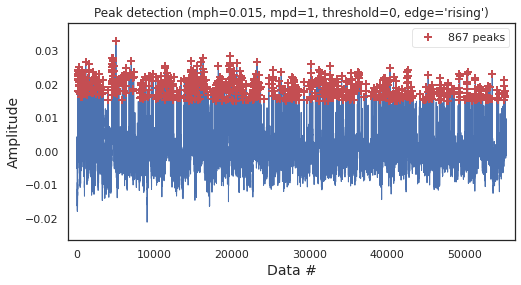

In [ ]:
ind = detect_peaks(observation_trace['data'], mph=0.015, show=True)

In [ ]:
v_around = []
points=5
filtered = savgol_filter(observation_trace['data'],81,2)
for i in ind:
  # v_around.append(np.mean(observation_trace['data'][i-points:i])) #observation_trace['data'][i+points]) #
  v_around.append(filtered[i])

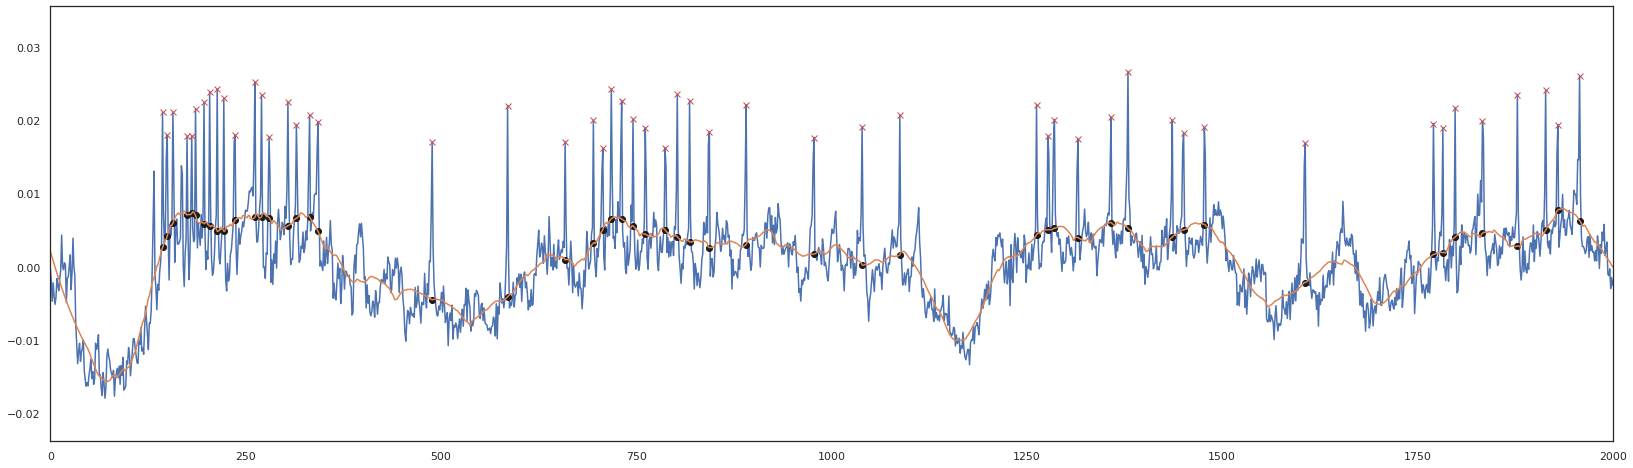

In [ ]:
plt.figure(figsize=(28,8))
plt.plot(observation_trace['time'],observation_trace['data'])
plt.plot(observation_trace['time'][ind],observation_trace['data'][ind],'rx')
plt.plot(observation_trace['time'][ind],v_around,'ko')
plt.plot(observation_trace['time'],savgol_filter(observation_trace['data'],81,2))
plt.xlim([0,observation_trace['time'][-1]])
plt.xlim([0,2000])

plt.savefig(f"{images_dir}/sample.png")
plt.savefig(f"{images_dir}/sample.pdf")  

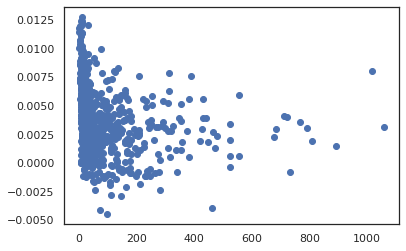

In [ ]:
X = np.array([np.diff(observation_trace['time'][ind[1:]]).tolist(), (v_around[1:-1])])
X=X.T
plt.scatter(X[:,0],X[:,1])

In [ ]:
# k_means = KMeans(init = "k-means++", n_clusters = 2, n_init = 20) #kmeans does not seem appropriate
# k_means.fit(X)
# k_means_labels =k_means.labels_
# k_means_cluster_centers = k_means.cluster_centers_
kmedoids = KMedoids(n_clusters=2, random_state=0).fit(X)
k_means_labels =kmedoids.labels_
k_means_cluster_centers = kmedoids.cluster_centers_

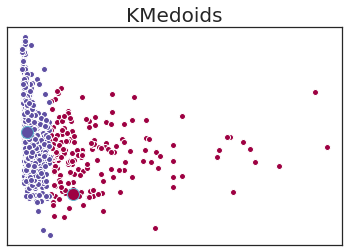

In [ ]:
# Initialize the plot with the specified dimensions.
fig = plt.figure(figsize=(6, 4))

# Colors uses a color map, which will produce an array of colors based on
# the number of labels there are. We use set(k_means_labels) to get the
# unique labels.
colors = plt.cm.Spectral(np.linspace(0, 1, len(set(k_means_labels))))

# Create a plot
ax = fig.add_subplot(1, 1, 1)

# For loop that plots the data points and centroids.
# k will range from 0-3, which will match the possible clusters that each
# data point is in.
for k, col in zip(range(len([[1,2],  [0, 3]])), colors): #[-2, -1], [2, -3],

    # Create a list of all data points, where the data points that are 
    # in the cluster (ex. cluster 0) are labeled as true, else they are
    # labeled as false.
    my_members = (k_means_labels == k)
    
    # Define the centroid, or cluster center.
    cluster_center = k_means_cluster_centers[k]
    
    # Plots the datapoints with color col.
    ax.plot(X[my_members, 0], X[my_members, 1], 'w', markerfacecolor=col, marker='o')

    # Plots the centroids with specified color, but with a darker outline
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,  markeredgecolor='c', markersize=12)

# Title of the plot
ax.set_title('KMedoids')

# Remove x-axis ticks
ax.set_xticks(())

# Remove y-axis ticks
ax.set_yticks(())

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
  item.set_fontsize(20)

plt.savefig(f"{images_dir}/KMedoids.png")
plt.savefig(f"{images_dir}/KMedoids.pdf")  

In [ ]:
my_members = (k_means_labels == 0)
df1 = pd.DataFrame({ 'ISI (ms)': X[my_members, 0], 'SBR' : X[my_members, 1], 'kind': 0})
my_members = (k_means_labels == 1)
df2 = pd.DataFrame({ 'ISI (ms)': X[my_members, 0], 'SBR' : X[my_members, 1], 'kind': 1 })

frames = [df1, df2]

result = pd.concat(frames,ignore_index=True)

<Figure size 864x720 with 0 Axes>

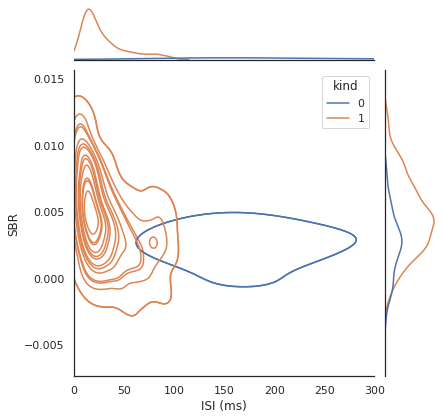

In [ ]:
plt.figure(figsize=(12,10))
g = sns.jointplot(data=result, x="ISI (ms)", y="SBR", hue='kind',kind='kde',xlim=[0,300])
g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6)
g.plot_marginals(sns.rugplot, color="r", height=-.001, clip_on=False)


plt.savefig(f"{images_dir}/KDE_KMedoids.png")
plt.savefig(f"{images_dir}/KDE_KMedoids.pdf")  

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_agglomerative.py:282: UserWarning: the number of connected components of the connectivity matrix is 120 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


<Figure size 1512x936 with 0 Axes>

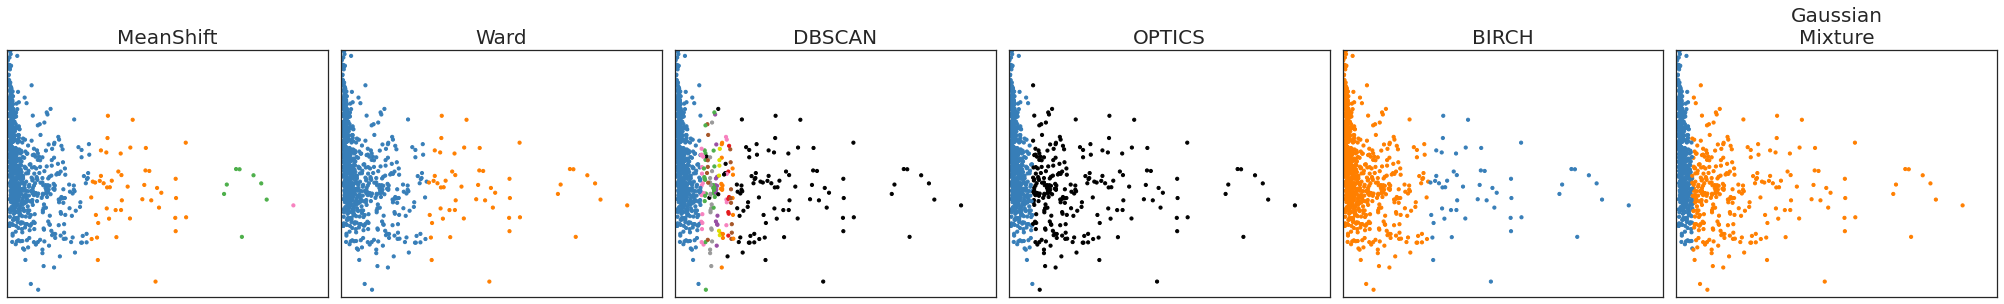

In [ ]:
np.random.seed(0)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.7,
    "eps": 2.0,
    "damping": 0.6,
    "preference": None,
    "n_neighbors": 2,
    "n_clusters": 2,
    "min_samples": 2,
    "xi": 0.05,
    "min_cluster_size": 0.1,
}
X = np.array([np.diff(observation_trace['time'][ind[1:]]).tolist(), (v_around[1:-1])])
X=X.T

datasets = X

plt.figure(figsize=(28,8))
for bla in range(1):

    # update parameters with dataset-specific values
    params = default_base.copy()

#     # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

#     # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
#     # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

#     # ============
#     # Create cluster objects
#     # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
    )
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        assign_labels='discretize',
        random_state=0,
        # eigen_solver="amg",
        # affinity='chi2',
        # affinity="nearest_neighbors",
    )
    dbscan = cluster.DBSCAN(eps=params["eps"])
    optics = cluster.OPTICS(
        min_samples=params["min_samples"],
        xi=params["xi"],
        min_cluster_size=params["min_cluster_size"],
    )

    birch = cluster.Birch(n_clusters=params["n_clusters"])
    gmm = mixture.GaussianMixture(
        n_components=params["n_clusters"], covariance_type="full"
    )

    clustering_algorithms = (
        ("MeanShift", ms),
        ("Ward", ward),
        ("DBSCAN", dbscan),
        ("OPTICS", optics),
        ("BIRCH", birch),
        ("Gaussian\nMixture", gmm),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        ax=plt.subplot(len(X[0,:]), len(clustering_algorithms), plot_num)
        plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(0, 1000)
        plt.ylim(-0.005, 0.0125)
        plt.xticks(())
        plt.yticks(())
        # plt.text(
        #     0.99,
        #     0.01,
        #     ("%.2fs" % (t1 - t0)).lstrip("0"),
        #     transform=plt.gca().transAxes,
        #     size=15,
        #     horizontalalignment="right",
        # )
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
          item.set_fontsize(20)
        plot_num += 1

plt.savefig(f"{images_dir}/clusters.png")
plt.savefig(f"{images_dir}/clusters.pdf")  
plt.tight_layout()
plt.show()

### Using only the ISIs 

In [ ]:
X = np.array(np.diff(observation_trace['time'][ind[1:]]).tolist())

In [ ]:
kmedoids = KMedoids(n_clusters=2, random_state=0).fit(X.reshape(-1,1))
k_means_labels =kmedoids.labels_
k_means_cluster_centers = kmedoids.cluster_centers_

In [ ]:
k_means_cluster_centers

array([[176.206],
       [ 19.311]])

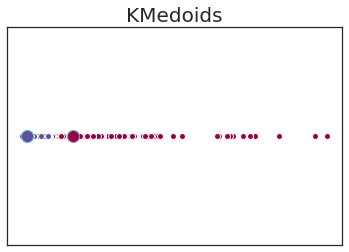

In [ ]:
# Initialize the plot with the specified dimensions.
fig = plt.figure(figsize=(6, 4))

# Colors uses a color map, which will produce an array of colors based on
# the number of labels there are. We use set(k_means_labels) to get the
# unique labels.
colors = plt.cm.Spectral(np.linspace(0, 1, len(set(k_means_labels))))

# Create a plot
ax = fig.add_subplot(1, 1, 1)

# For loop that plots the data points and centroids.
# k will range from 0-3, which will match the possible clusters that each
# data point is in.
for k, col in zip(range(len([[1,2],  [0, 3]])), colors): #[-2, -1], [2, -3],

    # Create a list of all data points, where the data points that are 
    # in the cluster (ex. cluster 0) are labeled as true, else they are
    # labeled as false.
    my_members = (k_means_labels == k)
    
    # Define the centroid, or cluster center.
    cluster_center = k_means_cluster_centers[k]
    
    # Plots the datapoints with color col.
    ax.plot(X[my_members], np.ones(len(X[my_members])), 'w', markerfacecolor=col, marker='o')

    # Plots the centroids with specified color, but with a darker outline
    ax.plot(cluster_center,np.ones(len(cluster_center)), 'o', markerfacecolor=col,  markeredgecolor='c', markersize=12)

# Title of the plot
ax.set_title('KMedoids')

# Remove x-axis ticks
ax.set_xticks(())

# Remove y-axis ticks
ax.set_yticks(())

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
  item.set_fontsize(20)

In [ ]:
###Kmeans
X = np.array(np.diff(observation_trace['time'][ind[1:]]).tolist())
k_means = KMeans(init = "k-means++", n_clusters = 2, n_init = 20).fit(X.reshape(-1,1))
k_means_labels =k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_
k_means_cluster_centers

array([[430.73341818],
       [ 47.67763635]])

[[  31.92100067]
 [ 481.2494625 ]
 [ 737.1109    ]
 [1038.53315   ]]


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_agglomerative.py:282: UserWarning: the number of connected components of the connectivity matrix is 138 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


no clusters
no clusters


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_optics.py:932: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


no clusters
no clusters
no clusters


<Figure size 1512x936 with 0 Axes>

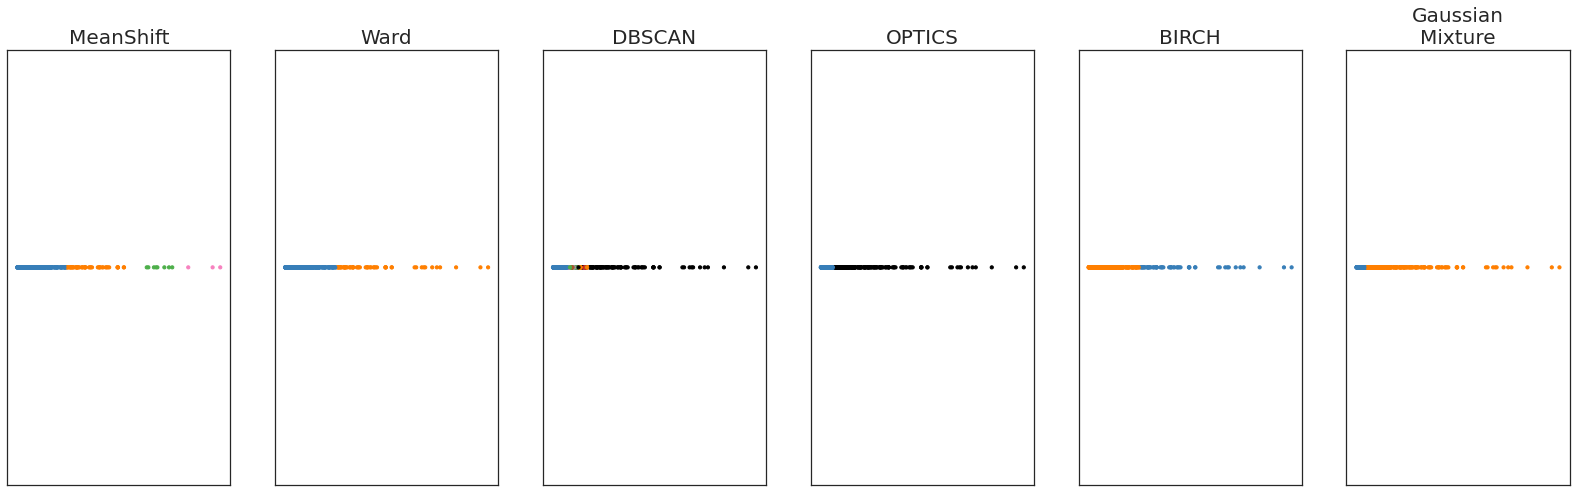

In [ ]:
np.random.seed(0)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.7,
    "eps": 2.0,
    "damping": 0.6,
    "preference": None,
    "n_neighbors": 2,
    "n_clusters": 2,
    "min_samples": 2,
    "xi": 0.05,
    "min_cluster_size": 0.1,
}
X = np.array(np.diff(observation_trace['time'][ind[1:]]).tolist())
X=X.T
X = X.reshape(-1,1)
datasets = X

plt.figure(figsize=(28,8))
for bla in range(1):

    # update parameters with dataset-specific values
    params = default_base.copy()

#     # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

#     # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
#     # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

#     # ============
#     # Create cluster objects
#     # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
    )
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        assign_labels='discretize',
        random_state=0,
        # eigen_solver="amg",
        # affinity='chi2',
        # affinity="nearest_neighbors",
    )
    dbscan = cluster.DBSCAN(eps=params["eps"])
    optics = cluster.OPTICS(
        min_samples=params["min_samples"],
        xi=params["xi"],
        min_cluster_size=params["min_cluster_size"],
    )

    birch = cluster.Birch(n_clusters=params["n_clusters"])
    gmm = mixture.GaussianMixture(
        n_components=params["n_clusters"], covariance_type="full"
    )

    clustering_algorithms = (
        ("MeanShift", ms),
        ("Ward", ward),
        ("DBSCAN", dbscan),
        ("OPTICS", optics),
        ("BIRCH", birch),
        ("Gaussian\nMixture", gmm),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        algorithm.fit(X)


        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        ax=plt.subplot(len(X[0,:]), len(clustering_algorithms), plot_num)
        plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:], np.ones(len(X[:])), s=10, color=colors[y_pred])
        # plt.plot(X[:], np.ones(len(X[:])), 'w', markerfacecolor=col, marker='o')

        # plt.xlim(0, 1000)
        # plt.ylim(-0.005, 0.0125)
        plt.xticks(())
        plt.yticks(())
        # plt.text(
        #     0.99,
        #     0.01,
        #     ("%.2fs" % (t1 - t0)).lstrip("0"),
        #     transform=plt.gca().transAxes,
        #     size=15,
        #     horizontalalignment="right",
        # )
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
          item.set_fontsize(20)
        plot_num += 1
        try:
          print(algorithm.cluster_centers_)
        except:
          print('no clusters')

In [ ]:
col

array([0.36862745, 0.30980392, 0.63529412, 1.        ])